In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dhdrnet.util import DATA_DIR, ROOT_DIR


figdir = ROOT_DIR / "figures"

In [3]:
df = (
    pd.read_csv(
        ROOT_DIR / "precomputed_data" / "store_2020-10-27.csv", index_col=0
    )
    .drop(columns="ev1")
    .rename(columns={"ev2": "ev"})
)
names = pd.read_csv(ROOT_DIR / "precomputed_data" / "test_current.csv")
df = df[df["name"].isin(names["names"])]
df = df.drop_duplicates()
df

,ev,name,metric,score
1584,-3.00,5066_20160724_121618_110,rmse,16.201134
1585,-3.00,5066_20160724_121618_110,psnr,23.939895
1586,-3.00,5066_20160724_121618_110,ssim,0.965922
1587,-3.00,5066_20160724_121618_110,perceptual,0.047302
1588,-2.75,5066_20160724_121618_110,rmse,16.540948
...,...,...,...,...
523723,5.75,0043_20160923_122514_781,perceptual,0.148934
523724,6.00,0043_20160923_122514_781,rmse,35.136912
523725,6.00,0043_20160923_122514_781,psnr,17.215532
523726,6.00,0043_20160923_122514_781,ssim,0.877194


In [4]:
grouped = df.set_index("name").groupby(["metric"])
grouped.describe()["score"][["mean", "std"]]

,mean,std
metric,,
perceptual,0.152325,0.112680
psnr,18.004786,5.801761
rmse,39.081830,23.139358
ssim,0.769130,0.231517


In [5]:
idxmins = (
    df[(df["metric"] == "perceptual") | (df["metric"] == "rmse")]
    .groupby(["name", "metric"])["score"]
    .idxmin()
)
best_scores_min = df.loc[idxmins]
best_scores_min
# this is the minimum score for each metric for each image
# unfortunately we want min for mse and perceptual
# and maxes for psnr, ssim

,ev,name,metric,score
188143,2.00,0006_20160721_170707_736,perceptual,0.031581
188168,3.75,0006_20160721_170707_736,rmse,11.903806
286935,2.50,0006_20160721_175239_909,perceptual,0.058179
286956,4.00,0006_20160721_175239_909,rmse,9.563386
377243,3.75,0006_20160721_181525_062,perceptual,0.049348
...,...,...,...,...
413372,3.00,c483_20150901_195108_436,rmse,19.015955
71359,2.00,c483_20150901_214630_530,perceptual,0.059056
71380,3.50,c483_20150901_214630_530,rmse,8.471777
71967,4.00,c483_20150901_221141_886,perceptual,0.043705


In [6]:
idxmaxs = (
    df[(df["metric"] == "psnr") | (df["metric"] == "ssim")]
    .groupby(["name", "metric"])["score"]
    .idxmax()
)
best_scores_max = df.loc[idxmaxs]
best_scores_max

,ev,name,metric,score
188169,3.75,0006_20160721_170707_736,psnr,26.617087
188142,2.00,0006_20160721_170707_736,ssim,0.975438
286957,4.00,0006_20160721_175239_909,psnr,28.518569
286958,4.00,0006_20160721_175239_909,ssim,0.965298
377245,4.00,0006_20160721_181525_062,psnr,26.302924
...,...,...,...,...
413374,3.00,c483_20150901_195108_436,ssim,0.971811
71381,3.50,c483_20150901_214630_530,psnr,29.571314
71386,3.75,c483_20150901_214630_530,ssim,0.970954
71957,3.50,c483_20150901_221141_886,psnr,31.740585


In [61]:
best_scores_df = pd.concat([best_scores_min, best_scores_max])
oracle = best_scores_df.groupby(["metric"]).describe()["score"][["mean", "std"]]
oracle

,mean,std
metric,,
perceptual,0.037905,0.024077
psnr,29.075697,5.774687
rmse,10.717247,5.932719
ssim,0.973383,0.014968


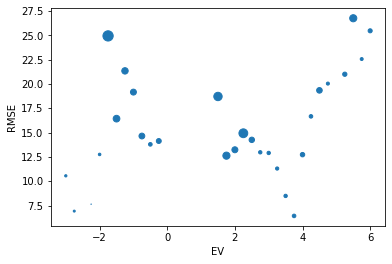

<Figure size 432x288 with 0 Axes>

In [115]:
oracle_by_ev = best_scores_df.groupby(["metric", "ev"]).describe()["score"]
plt.scatter(
    x=oracle_by_ev["mean"]["rmse"].index,
    y=oracle_by_ev["mean"]["rmse"],
    s=oracle_by_ev["std"]["rmse"]**2,
)
plt.xlabel("EV")
plt.ylabel("RMSE")
plt.show()
plt.savefig(figdir/ "RMSE_best_scores.pdf")

In [9]:
df.loc[df["ev"] == 3.5].groupby("metric").describe()["score"][["mean", "std"]]

,mean,std
metric,,
perceptual,0.055462,0.038827
psnr,26.724160,5.663801
rmse,14.507083,10.176345
ssim,0.961232,0.023200


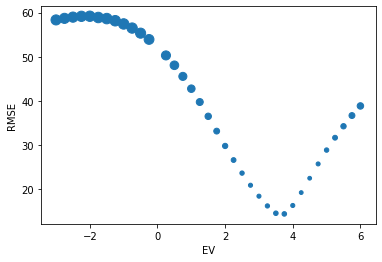

<Figure size 432x288 with 0 Axes>

In [113]:
df_by_metric = df.groupby(["metric", "ev"]).describe()["score"]
plt.scatter(
    x=df_by_metric["mean"]["rmse"].index, 
    y=df_by_metric["mean"]["rmse"], 
    s=0.2*df_by_metric["std"]["rmse"]**2
)
plt.xlabel("EV")
plt.ylabel("RMSE")
plt.show()
plt.savefig(figdir / "RMSE_by_ev.pdf")

In [11]:
df.loc[df["ev"] == 3.5].groupby("metric").describe()["score"][["mean", "std"]].to_latex(
    figdir / "fixed_choice.tex"
)

In [12]:
cdf = pd.read_csv(ROOT_DIR / "precomputed_data" / "store_updown_2020-10-26.csv").drop_duplicates()
cdf.loc[cdf["metric"] == "rmse", "score"] = cdf.loc[
    cdf["metric"] == "rmse", "score"
].apply(np.sqrt)

cdf

,name,metric,ev,score
0,0030_20151008_105249_589,rmse,1,39.161667
1,0030_20151008_105249_589,psnr,1,16.273580
2,0030_20151008_105249_589,ssim,1,0.812035
3,0030_20151008_105249_589,rmse,2,25.583744
4,0030_20151008_105249_589,psnr,2,19.971522
...,...,...,...,...
10855,0043_20160923_122514_781,psnr,4,19.521871
10856,0043_20160923_122514_781,ssim,4,0.928805
10857,0043_20160923_122514_781,rmse,5,30.929737
10858,0043_20160923_122514_781,psnr,5,18.323279


In [13]:
cdf.groupby(["ev", "metric"]).describe()["score"][["mean", "std"]].to_latex(
    figdir / "conv_choice.tex"
)
cdf.groupby(["ev", "metric"]).describe()["score"][["mean", "std"]]

mean        std
ev metric                      
1  psnr    16.144820   4.237501
   rmse    44.319712  19.385214
   ssim     0.707827   0.226675
2  psnr    20.877057   5.383900
   rmse    27.334192  14.555937
   ssim     0.848401   0.141950
3  psnr    25.248919   3.031392
   rmse    14.784704   5.051738
   ssim     0.943758   0.033221
4  psnr    26.384000   3.998241
   rmse    13.644772   7.042175
   ssim     0.967228   0.020001
5  psnr    19.700461   3.322998
   rmse    28.345435  10.790692
   ssim     0.880723   0.058906

In [148]:
def parse_preds(pred_str):
    splits = pred_str.split(" ")
    return [float(s) for s in splits[1:-1] if len(s) > 0]

model_name = "rec"
model_df = pd.read_csv(ROOT_DIR/"precomputed_data" / f"{model_name}_preds.csv", index_col=0)
model_df["pred"] = model_df["pred"].apply(parse_preds)
model_df

,name,pred
0,0006_20160721_170707_736,"[4.25, 1.0, 2.5, 6.0, -0.5, -2.75, -0.75, -1.2..."
1,0006_20160721_175239_909,"[4.25, 1.0, 2.5, -0.5, -0.75, 6.0, -2.75, -1.2..."
2,0006_20160721_181525_062,"[4.25, 1.0, 2.5, 6.0, -0.75, -0.5, -2.75, -1.2..."
3,0006_20160722_100126_028,"[4.25, 1.0, 2.5, -0.75, -0.5, 6.0, -2.75, -1.2..."
4,0006_20160722_100951_201,"[4.25, 2.5, 1.0, -0.75, 6.0, -0.5, -2.75, -1.2..."
...,...,...
719,c483_20150901_173210_443,"[4.25, 1.0, 2.5, 6.0, -0.75, -0.5, -2.75, -1.2..."
720,c483_20150901_194029_165,"[4.25, 1.0, 2.5, 6.0, -0.75, -2.75, -0.5, 5.25..."
721,c483_20150901_195108_436,"[4.25, 1.0, 2.5, 6.0, -0.75, -0.5, -2.75, -1.2..."
722,c483_20150901_214630_530,"[4.25, 6.0, 1.0, 2.5, -0.75, -0.5, -2.75, -1.2..."


In [149]:
from dhdrnet.util import get_scores_for_preds, get_topk_score_df, get_pred

In [150]:
# joined = df.set_index("name").join(model_df.set_index("name"))
# joined.iloc[0]
df.iloc[0]

ev                              -3
name      5066_20160724_121618_110
metric                        rmse
score                      16.2011
Name: 1584, dtype: object

In [151]:
model_df.iloc[0]

name                             0006_20160721_170707_736
pred    [4.25, 1.0, 2.5, 6.0, -0.5, -2.75, -0.75, -1.2...
Name: 0, dtype: object

In [152]:
t = get_scores_for_preds(model_df, df)
t.groupby("metric").describe()["score"]  # These are the top-10 accuracies

,count,mean,std,min,25%,50%,75%,max
metric,,,,,,,,
perceptual,6892.0,0.163384,0.111802,0.003489,0.080238,0.131865,0.215342,0.640015
psnr,6892.0,17.076636,5.054912,7.166248,12.985611,16.941886,20.746514,35.662362
rmse,6892.0,41.811926,22.703703,4.201671,23.399927,36.261508,57.182043,111.744920
ssim,6892.0,0.749370,0.230272,0.049605,0.631014,0.834887,0.934858,0.993281


In [153]:
r = get_topk_score_df(t,k=1)
r

,ev,name,metric,score
188151,2.50,0006_20160721_170707_736,perceptual,0.048308
188176,4.25,0006_20160721_170707_736,rmse,13.822243
286935,2.50,0006_20160721_175239_909,perceptual,0.058179
286960,4.25,0006_20160721_175239_909,rmse,10.493872
377223,2.50,0006_20160721_181525_062,perceptual,0.051621
...,...,...,...,...
413366,2.50,c483_20150901_195108_436,ssim,0.953198
71365,2.50,c483_20150901_214630_530,psnr,27.256031
71366,2.50,c483_20150901_214630_530,ssim,0.965504
71969,4.25,c483_20150901_221141_886,psnr,27.609992


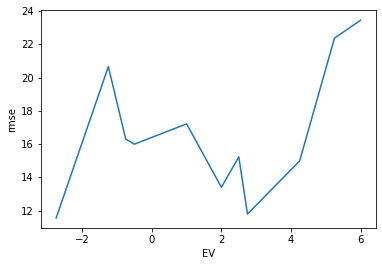

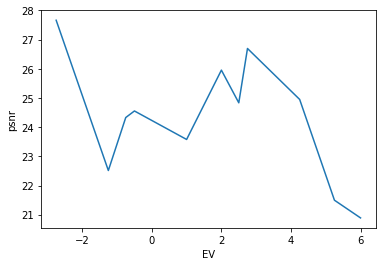

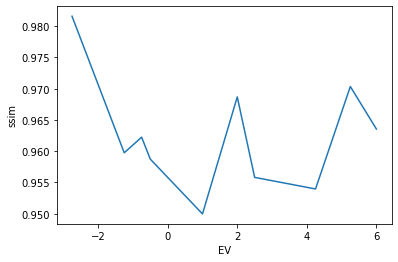

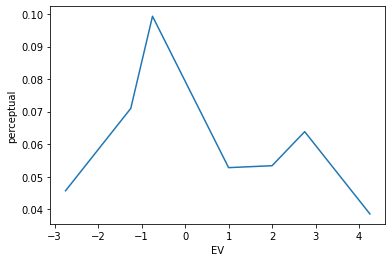

<Figure size 432x288 with 0 Axes>

In [154]:
model_by_ev = r.groupby(["metric", "ev"]).describe()["score"]
for metric in ["rmse", "psnr", "ssim", "perceptual"]:
    plt.plot(
        model_by_ev["mean"][metric].index,
        model_by_ev["mean"][metric],
#         model_by_ev["std"][metric]**2,
    )
    plt.xlabel("EV")
    plt.ylabel(metric)
    plt.show()
    plt.savefig(figdir / f"{model_name}_{metric}_by_ev.pdf")

In [20]:
t2 = get_pred(model_df, df)
t2.nunique()

ev          11
name       724
metric       4
score     2896
dtype: int64

In [21]:
t2.groupby("metric").describe()["score"][["mean", "std"]]

,mean,std
metric,,
perceptual,0.063436,0.030955
psnr,23.779427,4.231582
rmse,18.570024,9.325249
ssim,0.942271,0.040530


In [22]:
t2.groupby("metric").describe()["score"][["mean", "std"]]

,mean,std
metric,,
perceptual,0.063436,0.030955
psnr,23.779427,4.231582
rmse,18.570024,9.325249
ssim,0.942271,0.040530


In [23]:
r.groupby("metric").describe()["score"][["mean", "std"]]

,mean,std
metric,,
perceptual,0.043395,0.027587
psnr,28.611616,5.741699
rmse,11.303821,6.356376
ssim,0.969174,0.017469
